In [2]:
#whole lotta inputs ASTRO RELated
from astroquery.vizier import Vizier
import astropy.units as u

import matplotlib.pyplot as plt
import astropy.units as u
import csv
#from astropy.io import fits
from astropy.table import Table
#from astropy.wcs import WCS
#import astroquery
#from astropy.coordinates import SkyCoord
#from astroquery.mast import Observations
#from astroquery.mast import Catalogs
#from astroquery.mast import Tesscut



import numpy as np

#machine learning inputs
import sklearn as sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [4]:
galah = Table.read('/Users/alexabeyer/Desktop/research/data/GALAH_DR3_main_allstar_v2.fits')


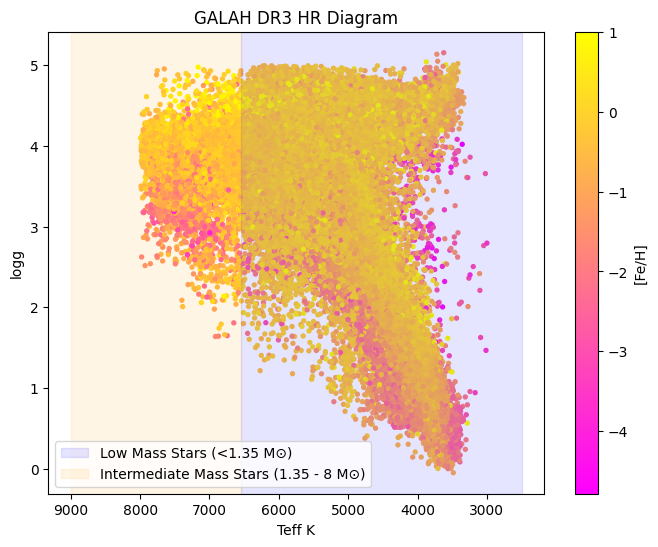

In [5]:
plt.figure(figsize=(8, 6))


sc = plt.scatter(galah['teff'], galah['logg'], c=galah['fe_h'], cmap='spring', s=8)
plt.colorbar(sc, label='[Fe/H]')
plt.gca().invert_xaxis()
plt.xlabel('Teff K')
plt.ylabel("logg")
# plt.ylim(-100,50e4)
plt.title("GALAH DR3 HR Diagram")

#Hr diagram markers 
teff = galah['teff']

# Plot shaded regions for mass groups
plt.axvspan(2500, 6550, color='blue', alpha=0.1, label='Low Mass Stars (<1.35 M⊙)')
plt.axvspan(6550, 9000, color='orange', alpha=0.1, label='Intermediate Mass Stars (1.35 - 8 M⊙)')

# # Annotating the regions (optional)
# plt.annotate('Low Mass Stars', xy=(4500, 5), xytext=(4500, 4.7),
#              arrowprops=dict(facecolor='blue', shrink=0.05), color='blue', fontsize=10)
# plt.annotate('Intermediate Mass Stars', xy=(6000, 4), xytext=(6000, 4.2),
#              arrowprops=dict(facecolor='orange', shrink=0.05), color='orange', fontsize=10)
# plt.annotate('High Mass Stars', xy=(18000, -2), xytext=(18000, -2.2),
#              arrowprops=dict(facecolor='red', shrink=0.05), color='red', fontsize=10)

# Show the plot
plt.legend()
plt.savefig('galah_hrdiagram.png')
plt.show()

In [9]:
def clustering(nclust, X, true_labels, centers_arg=True):
    kmeans = KMeans(n_clusters=nclust, random_state=0, n_init="auto").fit(X)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    # Sort cluster labels by Teff (column 0)
    sorted_indices = np.argsort(centers[:, 0])
    label_mapping = {old: new for new, old in enumerate(sorted_indices)}
    labels = np.vectorize(label_mapping.get)(labels)

    # Downsample for plotting
    x_plot = df['teff'].iloc[::5]
    y_plot = X['logg'].iloc[::5]

    # Create figure
    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    # Scatter plots
    points = axs[0].scatter(x_plot, y_plot, c=labels[::5], s=4)
    misclassified = labels[::5] - true_labels[::5]
    points_misclass = axs[1].scatter(x_plot, y_plot, c=misclassified, s=4, cmap='Set1')

    # Plot spectral lines and labels
    spectral_types_break = ['F0', 'Kraft Break', 'G0', 'K0', 'M0']
    teff_values = [7220, 6550, 5930, 5270, 3850]

    for ax in axs:
        y_top = ax.get_ylim()[1]
        for teff, label in zip(teff_values, spectral_types_break):
            ax.axvline(teff, color='black', linestyle='--', linewidth=0.8)
            y_offset = 0.3 if label != 'Kraft Break' else 1.2
            ax.text(teff, y_top - y_offset, label,
                    rotation=90 if label == 'Kraft Break' else 0,
                    verticalalignment='top',
                    horizontalalignment='center',
                    fontsize=9)
            
        if centers_arg:
            ax.scatter(centers[:, 0], centers[:, 1], marker='x', c='black', s=80, label='Centers')
        ax.set_title("GALAH Cluster HR Diagram")
        ax.set_xlabel('Temperature (K)')
        ax.set_ylabel(r'logg (cm^2s_1')
        ax.invert_xaxis()
        ax.legend()

    # Add colorbars
    fig.colorbar(points, ax=axs[0], label='Cluster label')
    fig.colorbar(points_misclass, ax=axs[1], label='Label Difference')

    plt.tight_layout()
    plt.savefig('gaia_tess_cluster5_HR.png')
    plt.show()

    return labels, centers

In [13]:
GALAH = galah["teff", #Effective temperature of the star (a derived quantity)
    #"e_Teff", #Error in effective temperature
    "logg", #Log surface gravity
    #"e_logg", #error in surface gravity
    "fe_h", #Metallicity (ratio of iron to hydrogen)
    #"e_FeH", #error in metallicit
    "vbroad" #rotational velocity 
]

df = GALAH.to_pandas()
df = df.dropna()
df

fitcols = [
    "teff", #Effective temperature of the star (a derived quantity)
    #"e_Teff", #Error in effective temperature
    "logg", #Log surface gravity
    #"e_logg", #error in surface gravity
    "fe_h", #Metallicity (ratio of iron to hydrogen)
    #"e_FeH", #error in metallicit
    "vbroad" #rotational velocity 
    
]

XT = df[fitcols]
y= df['teff']

masses = [
    df['teff'] < 5000,
    (df['teff'] >= 5000) & (df['teff'] < 7500),
    df['teff'] >= 7500
]

mass_labels = [0, 1, 2]


labels_5clust = np.select(masses, mass_labels)

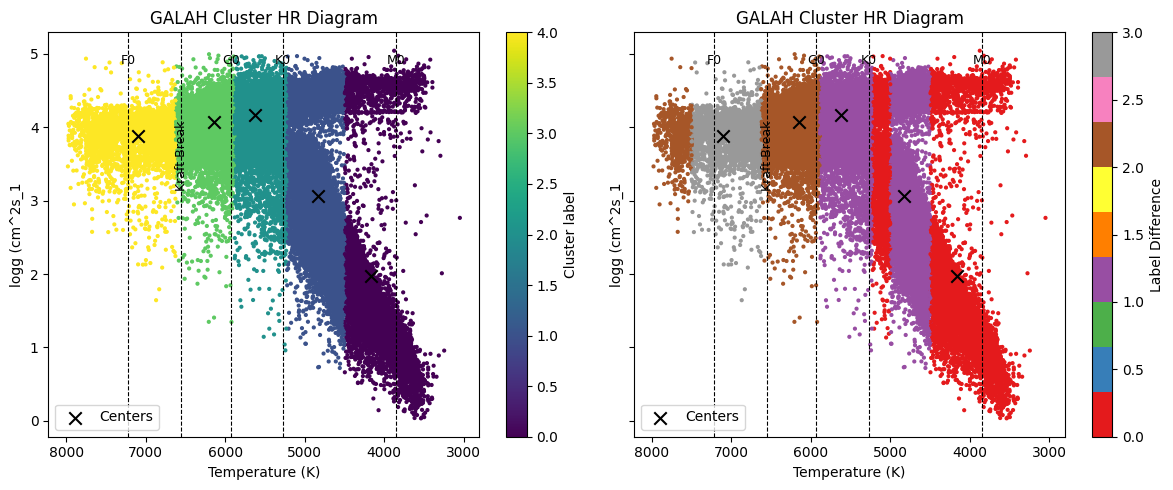

In [15]:
labels5, centers5 = clustering(5, XT, labels_5clust)